cuda:0


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.7MB/s]


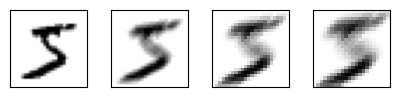

In [1]:
!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['axes.grid'] = True

np.set_printoptions(suppress=True, precision=5)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


data_root = './data'

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.MNIST(
    root = data_root,  train = True,
    download = True, transform = transform)

image, label = train_set[0]
image = image.view(1,1,28,28)

conv1 = nn.Conv2d(1, 1, 3)

nn.init.constant_(conv1.bias, 0.0)

w1_np = np.array([[0,0,1],[0,1,0],[1,0,0]])
w1 = torch.tensor(w1_np).float()
w1 = w1.view(1,1,3,3)
conv1.weight.data = w1

image, label = train_set[0]
image = image.view(1,1,28,28)
w1 = conv1(image)
w2 = conv1(w1)
w3 = conv1(w2)
images = [image, w1, w2, w3]

plt.figure(figsize=(5, 1))
for i in range(4):
    size = 28 - i*2
    ax = plt.subplot(1, 4, i+1)
    img = images[i].data.numpy()
    plt.imshow(img.reshape(size, size),cmap='gray_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [2]:
conv1 = nn.Conv2d(3, 32, 3)
relu = nn.ReLU(inplace=True)
conv2 = nn.Conv2d(32, 32, 3)
maxpool = nn.MaxPool2d((2,2))

In [3]:
print(conv1)
print(conv1.weight.shape)
print(conv1.bias.shape)

print(conv2.weight.shape)
print(conv2.bias.shape)

w = conv1.weight[0]

print(w.shape)
print(w.data.numpy())

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([3, 3, 3])
[[[-0.10177 -0.12981 -0.11998]
  [-0.14664 -0.06246 -0.00452]
  [ 0.01903  0.18875  0.01701]]

 [[-0.10548  0.07915 -0.02439]
  [ 0.17619 -0.08681 -0.11534]
  [ 0.12005  0.12877  0.15136]]

 [[ 0.09328 -0.11705  0.09606]
  [-0.05516 -0.04931  0.1024 ]
  [-0.07389 -0.06161  0.04013]]]


In [4]:
inputs = torch.randn(100, 3, 32, 32)
print(inputs.shape)

torch.Size([100, 3, 32, 32])


In [5]:
x1 = conv1(inputs)
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool(x4)

In [6]:
print(inputs.shape)
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)

torch.Size([100, 3, 32, 32])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 14, 14])


In [7]:
features = nn.Sequential(
    conv1,
    relu,
    conv2,
    relu,
    maxpool
)

In [8]:
outputs = features(inputs)

print(outputs.shape)

torch.Size([100, 32, 14, 14])


In [9]:
flatten = nn.Flatten()
outputs2 = flatten(outputs)

print(outputs.shape)
print(outputs2.shape)

torch.Size([100, 32, 14, 14])
torch.Size([100, 6272])


In [10]:
def eval_loss(loader, device, net, criterion):
    for images, labels in loader:
        break

    inputs = images.to(device)
    labels = labels.to(device)

    outputs = net(inputs)

    loss = criterion(outputs, labels)
    return loss

In [11]:
from tqdm.notebook import tqdm

def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):
    base_epochs = len(history)

    for epoch in range(base_epochs, num_epochs+base_epochs):
        n_train_acc, n_val_acc = 0, 0
        train_loss, val_loss = 0, 0
        n_train, n_test = 0, 0

        net.train()

        for inputs, labels in tqdm(train_loader):
            train_batch_size = len(labels)
            n_train += train_batch_size

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            predicted = torch.max(outputs, 1)[1]

            train_loss += loss.item() * train_batch_size
            n_train_acc += (predicted == labels).sum().item()

        net.eval()

        for inputs_test, labels_test in test_loader:
            test_batch_size = len(labels_test)
            n_test += test_batch_size

            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)

            outputs_test = net(inputs_test)

            loss_test = criterion(outputs_test, labels_test)

            predicted_test = torch.max(outputs_test, 1)[1]

            val_loss +=  loss_test.item() * test_batch_size
            n_val_acc +=  (predicted_test == labels_test).sum().item()

        train_acc = n_train_acc / n_train
        val_acc = n_val_acc / n_test

        avg_train_loss = train_loss / n_train
        avg_val_loss = val_loss / n_test

        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {val_acc:.5f}')

        item = np.array([epoch+1, avg_train_loss, train_acc, avg_val_loss, val_acc])
        history = np.vstack((history, item))

    return history

In [12]:
def evaluate_history(history):
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}')
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

In [13]:
def show_images_labels(loader, classes, net, device):
    for images, labels in loader:
        break

    n_size = min(len(images), 50)

    if net is not None:
      inputs = images.to(device)
      labels = labels.to(device)

      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]

    plt.figure(figsize=(20, 15))

    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]

        if net is not None:
          predicted_name = classes[predicted[i]]

          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)

        else:
          ax.set_title(label_name, fontsize=20)

        image_np = images[i].numpy().copy()
        img = np.transpose(image_np, (1, 2, 0))
        img = (img + 1)/2
        plt.imshow(img)
        ax.set_axis_off()

    plt.show()

In [14]:
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [15]:
transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])

transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

In [16]:
data_root = './data'

train_set1 = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = transform1)

test_set1 = datasets.CIFAR10(
    root = data_root, train = False,
    download = True, transform = transform1)

train_set2 = datasets.CIFAR10(
    root =  data_root, train = True,
    download = True, transform = transform2)

test_set2 = datasets.CIFAR10(
    root = data_root, train = False,
    download = True, transform = transform2)

100%|██████████| 170M/170M [00:04<00:00, 34.4MB/s]


In [17]:
image1, label1 = train_set1[0]
image2, label2 = train_set2[0]

print(image1.shape)
print(image2.shape)

torch.Size([3072])
torch.Size([3, 32, 32])


In [18]:
batch_size = 100

train_loader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True)

test_loader1 = DataLoader(test_set1,  batch_size=batch_size, shuffle=False)

train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

test_loader2 = DataLoader(test_set2,  batch_size=batch_size, shuffle=False)

In [19]:
for images1, labels1 in train_loader1:
    break

for images2, labels2 in train_loader2:
    break

print(images1.shape)
print(images2.shape)

torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


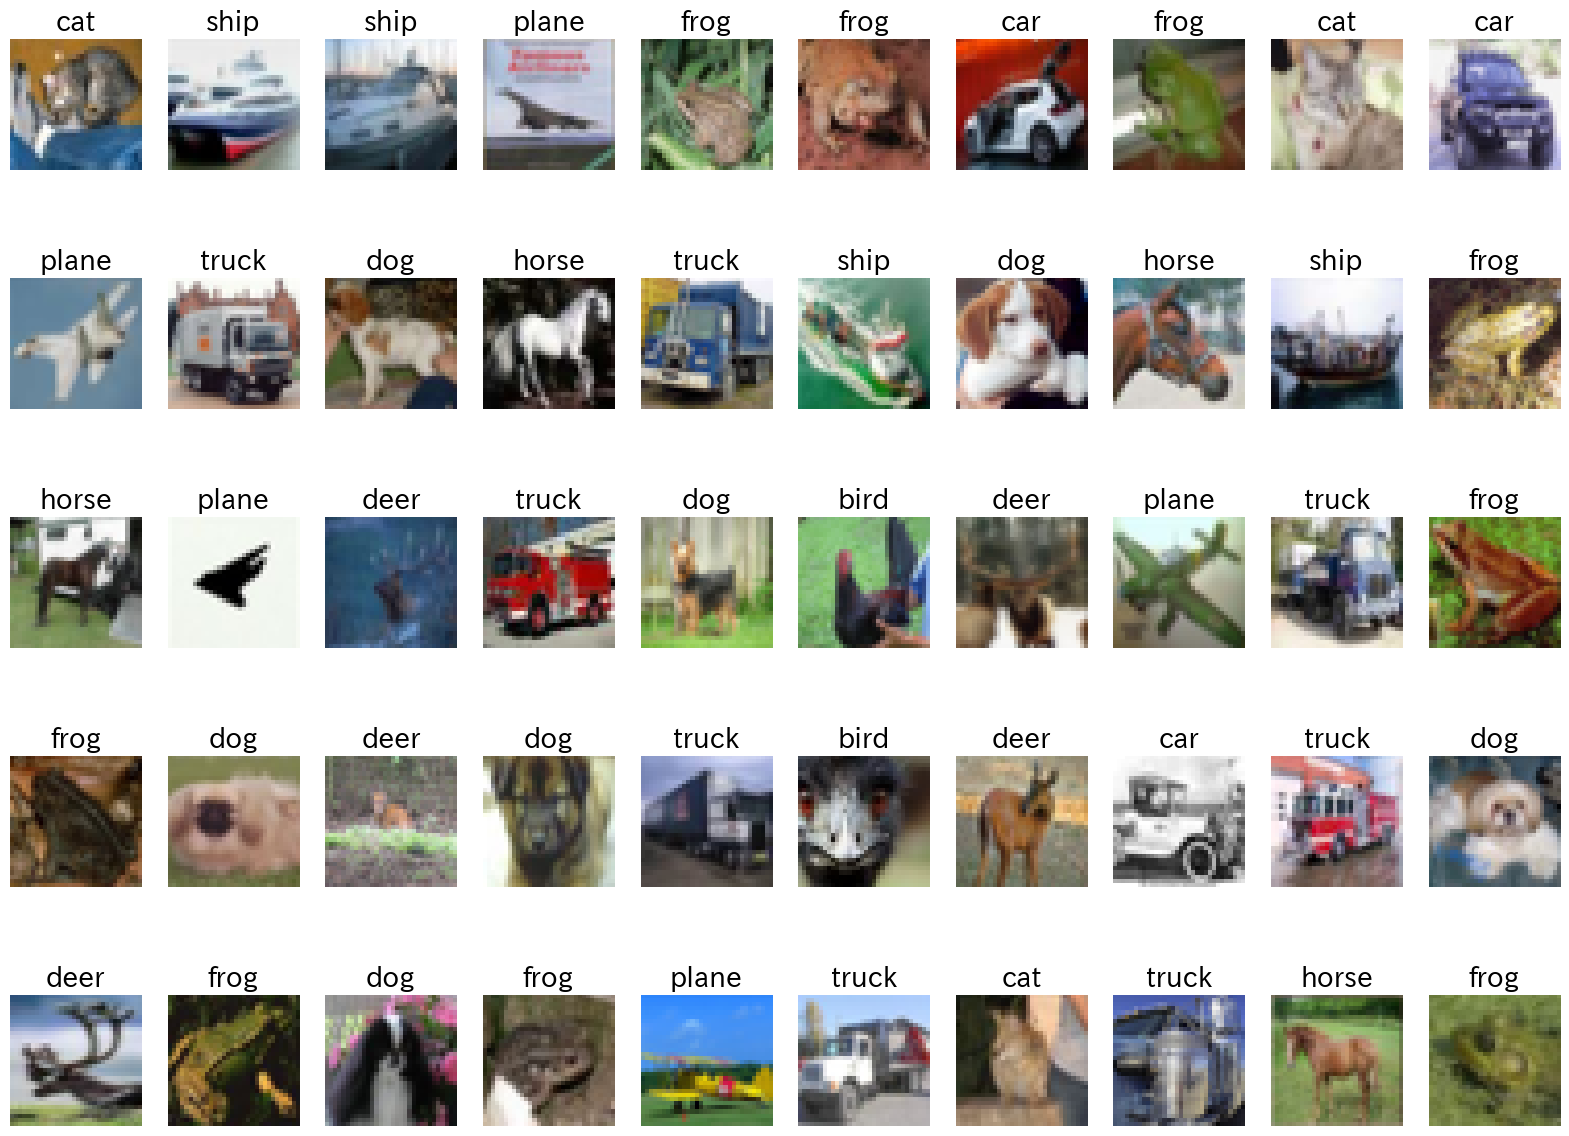

In [20]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

show_images_labels(test_loader2, classes, None, None)

In [21]:
n_input = image1.view(-1).shape[0]
n_output = len(classes)
n_hidden = 128

print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 3072  n_hidden: 128 n_output: 10


In [22]:
class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 隠れ層の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 出力層の定義
        self.l2 = nn.Linear(n_hidden, n_output)

        # ReLU関数の定義
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

Net(
  (l1): Linear(in_features=3072, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


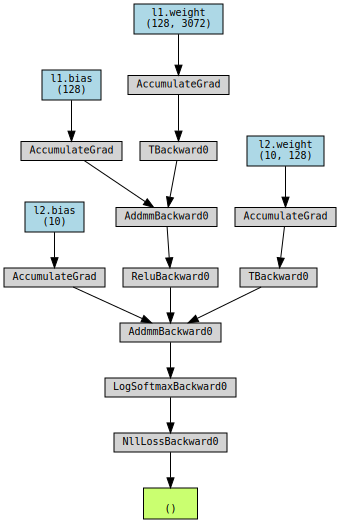

In [23]:
net = Net(n_input, n_output, n_hidden).to(device)

criterion = nn.CrossEntropyLoss()

lr = 0.01

optimizer = torch.optim.SGD(net.parameters(), lr=lr)

print(net)

summary(net, (100,3072),depth=1)

loss = eval_loss(test_loader1, device, net, criterion)

g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [24]:
torch_seed()

net = Net(n_input, n_output, n_hidden).to(device)

criterion = nn.CrossEntropyLoss()

lr = 0.01

optimizer = optim.SGD(net.parameters(), lr=lr)

num_epochs = 50

history = np.zeros((0,5))
history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.94965 acc: 0.32200 val_loss: 1.79429, val_acc: 0.37670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.73841 acc: 0.39572 val_loss: 1.68432, val_acc: 0.41710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.65503 acc: 0.42402 val_loss: 1.62232, val_acc: 0.43840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 1.60236 acc: 0.44248 val_loss: 1.58264, val_acc: 0.45120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 1.56324 acc: 0.45530 val_loss: 1.55321, val_acc: 0.46100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 1.53239 acc: 0.46754 val_loss: 1.52977, val_acc: 0.46890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 1.50495 acc: 0.47748 val_loss: 1.51237, val_acc: 0.47340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 1.48016 acc: 0.48604 val_loss: 1.49307, val_acc: 0.47770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 1.45696 acc: 0.49572 val_loss: 1.47975, val_acc: 0.48660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 1.43486 acc: 0.50454 val_loss: 1.46320, val_acc: 0.49010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 1.41334 acc: 0.51112 val_loss: 1.44996, val_acc: 0.49580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 1.39445 acc: 0.52008 val_loss: 1.43715, val_acc: 0.50260


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 1.37515 acc: 0.52678 val_loss: 1.42544, val_acc: 0.50590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 1.35715 acc: 0.53504 val_loss: 1.42276, val_acc: 0.50620


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 1.34075 acc: 0.53924 val_loss: 1.40745, val_acc: 0.51360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 1.32401 acc: 0.54590 val_loss: 1.40185, val_acc: 0.51110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 1.30727 acc: 0.55108 val_loss: 1.39068, val_acc: 0.51370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 1.29317 acc: 0.55716 val_loss: 1.38808, val_acc: 0.51450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 1.27843 acc: 0.56146 val_loss: 1.37912, val_acc: 0.51960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 1.26378 acc: 0.56694 val_loss: 1.38048, val_acc: 0.51770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 1.25104 acc: 0.57062 val_loss: 1.37178, val_acc: 0.51810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 1.23747 acc: 0.57726 val_loss: 1.36764, val_acc: 0.52580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 1.22498 acc: 0.58008 val_loss: 1.36257, val_acc: 0.52750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 1.21311 acc: 0.58402 val_loss: 1.35514, val_acc: 0.52440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 1.20024 acc: 0.59174 val_loss: 1.35186, val_acc: 0.52750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 1.18932 acc: 0.59382 val_loss: 1.35069, val_acc: 0.52900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 1.17750 acc: 0.59886 val_loss: 1.34905, val_acc: 0.52720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 1.16652 acc: 0.60206 val_loss: 1.34329, val_acc: 0.52960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 1.15559 acc: 0.60540 val_loss: 1.34190, val_acc: 0.52840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 1.14474 acc: 0.60976 val_loss: 1.34557, val_acc: 0.53010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 1.13463 acc: 0.61516 val_loss: 1.34062, val_acc: 0.53010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 1.12405 acc: 0.61786 val_loss: 1.33800, val_acc: 0.52870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 1.11450 acc: 0.62116 val_loss: 1.33794, val_acc: 0.53070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 1.10485 acc: 0.62616 val_loss: 1.34166, val_acc: 0.52810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 1.09511 acc: 0.62846 val_loss: 1.34095, val_acc: 0.52730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 1.08563 acc: 0.63218 val_loss: 1.33393, val_acc: 0.53210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 1.07644 acc: 0.63564 val_loss: 1.33957, val_acc: 0.52820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 1.06731 acc: 0.63948 val_loss: 1.33592, val_acc: 0.53080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 1.05906 acc: 0.64206 val_loss: 1.34138, val_acc: 0.53010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 1.05024 acc: 0.64520 val_loss: 1.34845, val_acc: 0.52430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 1.04051 acc: 0.64904 val_loss: 1.33987, val_acc: 0.52840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 1.03267 acc: 0.65044 val_loss: 1.34742, val_acc: 0.52820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 1.02514 acc: 0.65418 val_loss: 1.34666, val_acc: 0.52500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 1.01624 acc: 0.65598 val_loss: 1.34640, val_acc: 0.52490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 1.00700 acc: 0.65942 val_loss: 1.34491, val_acc: 0.52630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 1.00024 acc: 0.66198 val_loss: 1.34359, val_acc: 0.53020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.99316 acc: 0.66424 val_loss: 1.34748, val_acc: 0.52600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.98445 acc: 0.66810 val_loss: 1.35069, val_acc: 0.52960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.97678 acc: 0.67072 val_loss: 1.36345, val_acc: 0.52110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.97024 acc: 0.67242 val_loss: 1.35274, val_acc: 0.53100


初期状態: 損失: 1.79429 精度: 0.37670
最終状態: 損失: 1.35274 精度: 0.53100


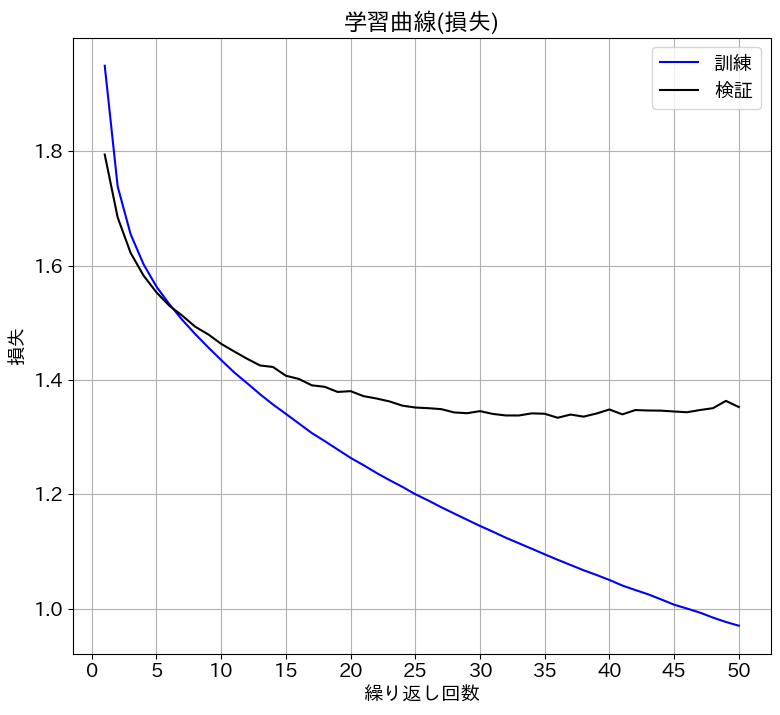

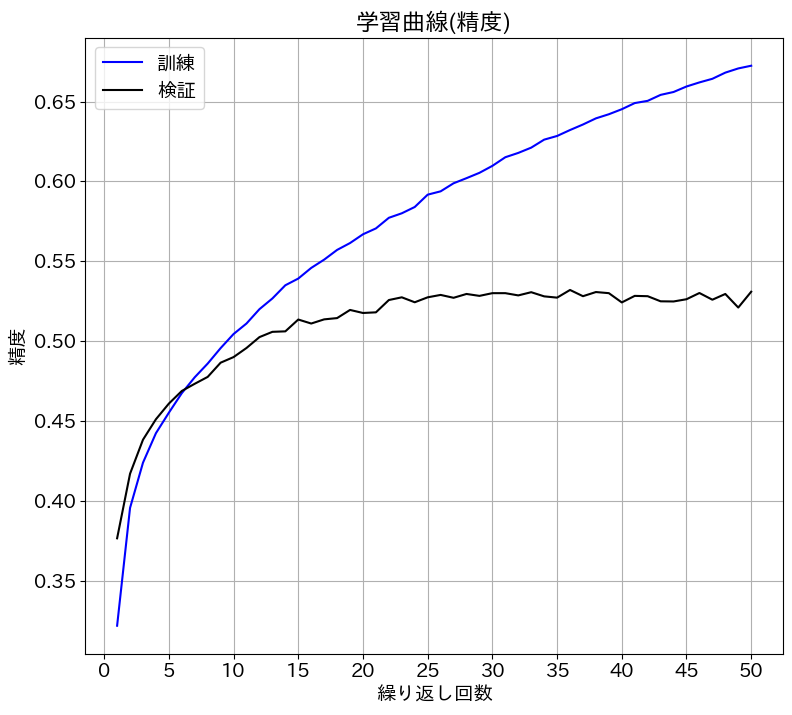

In [25]:
evaluate_history(history)

In [26]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(6272, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)

    self.classifier = nn.Sequential(
       self.l1,
       self.relu,
       self.l2)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=6272, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


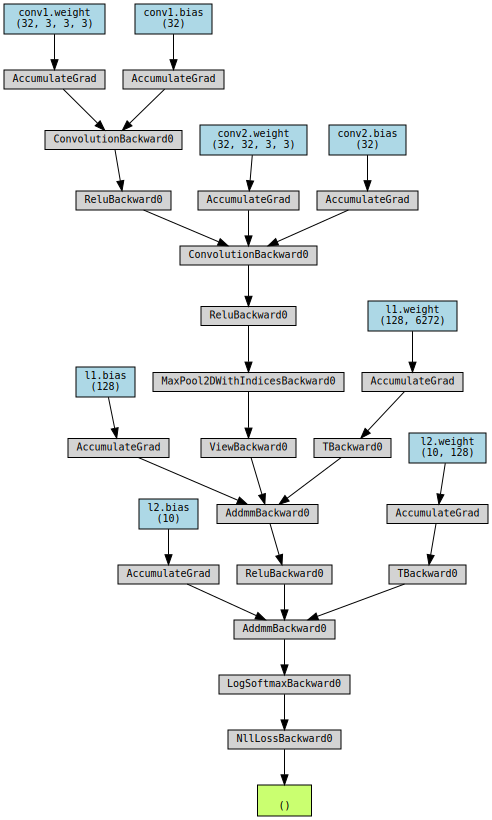

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 2.08243 acc: 0.26098 val_loss: 1.86593, val_acc: 0.34660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.78082 acc: 0.37294 val_loss: 1.67640, val_acc: 0.40930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.61329 acc: 0.43080 val_loss: 1.53017, val_acc: 0.46030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 1.48548 acc: 0.47300 val_loss: 1.44976, val_acc: 0.48930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 1.40812 acc: 0.49928 val_loss: 1.36944, val_acc: 0.51320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 1.34998 acc: 0.52116 val_loss: 1.33274, val_acc: 0.52600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 1.30348 acc: 0.53738 val_loss: 1.29266, val_acc: 0.53940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 1.25270 acc: 0.55526 val_loss: 1.25218, val_acc: 0.55280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 1.20495 acc: 0.57302 val_loss: 1.23524, val_acc: 0.56280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 1.15756 acc: 0.59204 val_loss: 1.18364, val_acc: 0.58020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 1.11616 acc: 0.60840 val_loss: 1.16442, val_acc: 0.58880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 1.07733 acc: 0.62314 val_loss: 1.16879, val_acc: 0.58090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 1.03552 acc: 0.63690 val_loss: 1.11042, val_acc: 0.60670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.99755 acc: 0.65072 val_loss: 1.08889, val_acc: 0.61160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.95914 acc: 0.66478 val_loss: 1.11037, val_acc: 0.60330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.92229 acc: 0.67584 val_loss: 1.05425, val_acc: 0.63080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.88174 acc: 0.69306 val_loss: 1.06657, val_acc: 0.62480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.84649 acc: 0.70402 val_loss: 1.01046, val_acc: 0.64850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.80875 acc: 0.71990 val_loss: 1.01902, val_acc: 0.63970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.77377 acc: 0.73090 val_loss: 1.04280, val_acc: 0.63640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.73867 acc: 0.74154 val_loss: 1.00009, val_acc: 0.65190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.70099 acc: 0.75752 val_loss: 1.01147, val_acc: 0.65310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.67352 acc: 0.76636 val_loss: 0.99128, val_acc: 0.65910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.63698 acc: 0.77880 val_loss: 1.00853, val_acc: 0.65950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.60293 acc: 0.79386 val_loss: 1.00246, val_acc: 0.66600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.56777 acc: 0.80546 val_loss: 1.06284, val_acc: 0.64480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.53912 acc: 0.81586 val_loss: 1.05158, val_acc: 0.66390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.50728 acc: 0.82760 val_loss: 1.11132, val_acc: 0.64490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47320 acc: 0.84066 val_loss: 1.06459, val_acc: 0.66220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.44119 acc: 0.85132 val_loss: 1.09777, val_acc: 0.65700


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.40781 acc: 0.86312 val_loss: 1.10238, val_acc: 0.66570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.37884 acc: 0.87404 val_loss: 1.13901, val_acc: 0.65760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.35217 acc: 0.88374 val_loss: 1.13233, val_acc: 0.66230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.32349 acc: 0.89264 val_loss: 1.29153, val_acc: 0.64280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.29428 acc: 0.90412 val_loss: 1.30408, val_acc: 0.64710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.26805 acc: 0.91404 val_loss: 1.28169, val_acc: 0.65240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.23933 acc: 0.92404 val_loss: 1.26104, val_acc: 0.66720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.21603 acc: 0.93266 val_loss: 1.33323, val_acc: 0.66020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.19463 acc: 0.94128 val_loss: 1.35400, val_acc: 0.66190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.16768 acc: 0.95210 val_loss: 1.42177, val_acc: 0.65760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.14228 acc: 0.96174 val_loss: 1.48085, val_acc: 0.65780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.13092 acc: 0.96512 val_loss: 1.54216, val_acc: 0.65030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.11047 acc: 0.97326 val_loss: 1.55151, val_acc: 0.65930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.10131 acc: 0.97624 val_loss: 1.58512, val_acc: 0.66410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.08463 acc: 0.98198 val_loss: 1.62197, val_acc: 0.66240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.05680 acc: 0.99140 val_loss: 1.72798, val_acc: 0.65680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.04431 acc: 0.99494 val_loss: 1.73316, val_acc: 0.66620


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.03580 acc: 0.99666 val_loss: 1.79444, val_acc: 0.66130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.02881 acc: 0.99784 val_loss: 1.85386, val_acc: 0.66070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.02414 acc: 0.99842 val_loss: 1.88229, val_acc: 0.66350
初期状態: 損失: 1.86593 精度: 0.34660
最終状態: 損失: 1.88229 精度: 0.66350


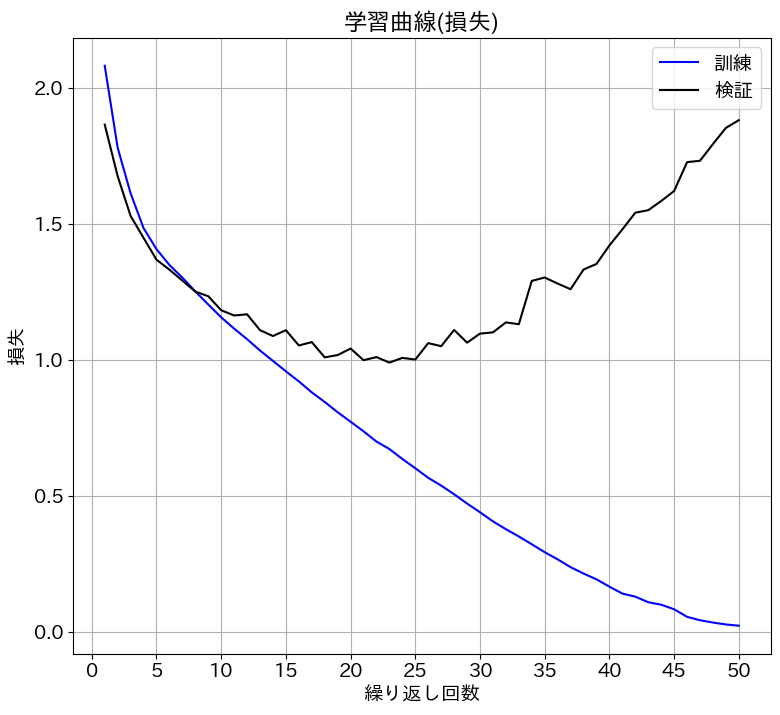

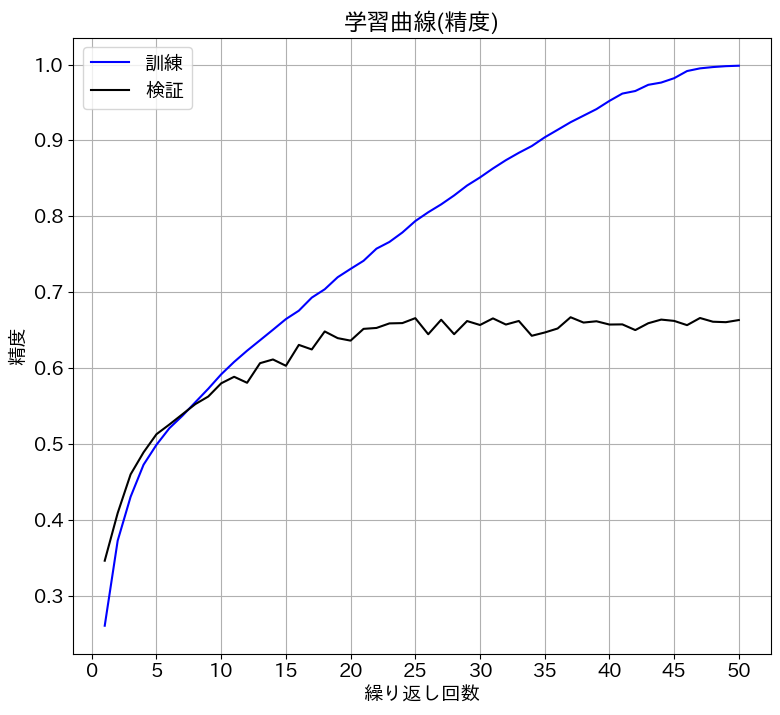

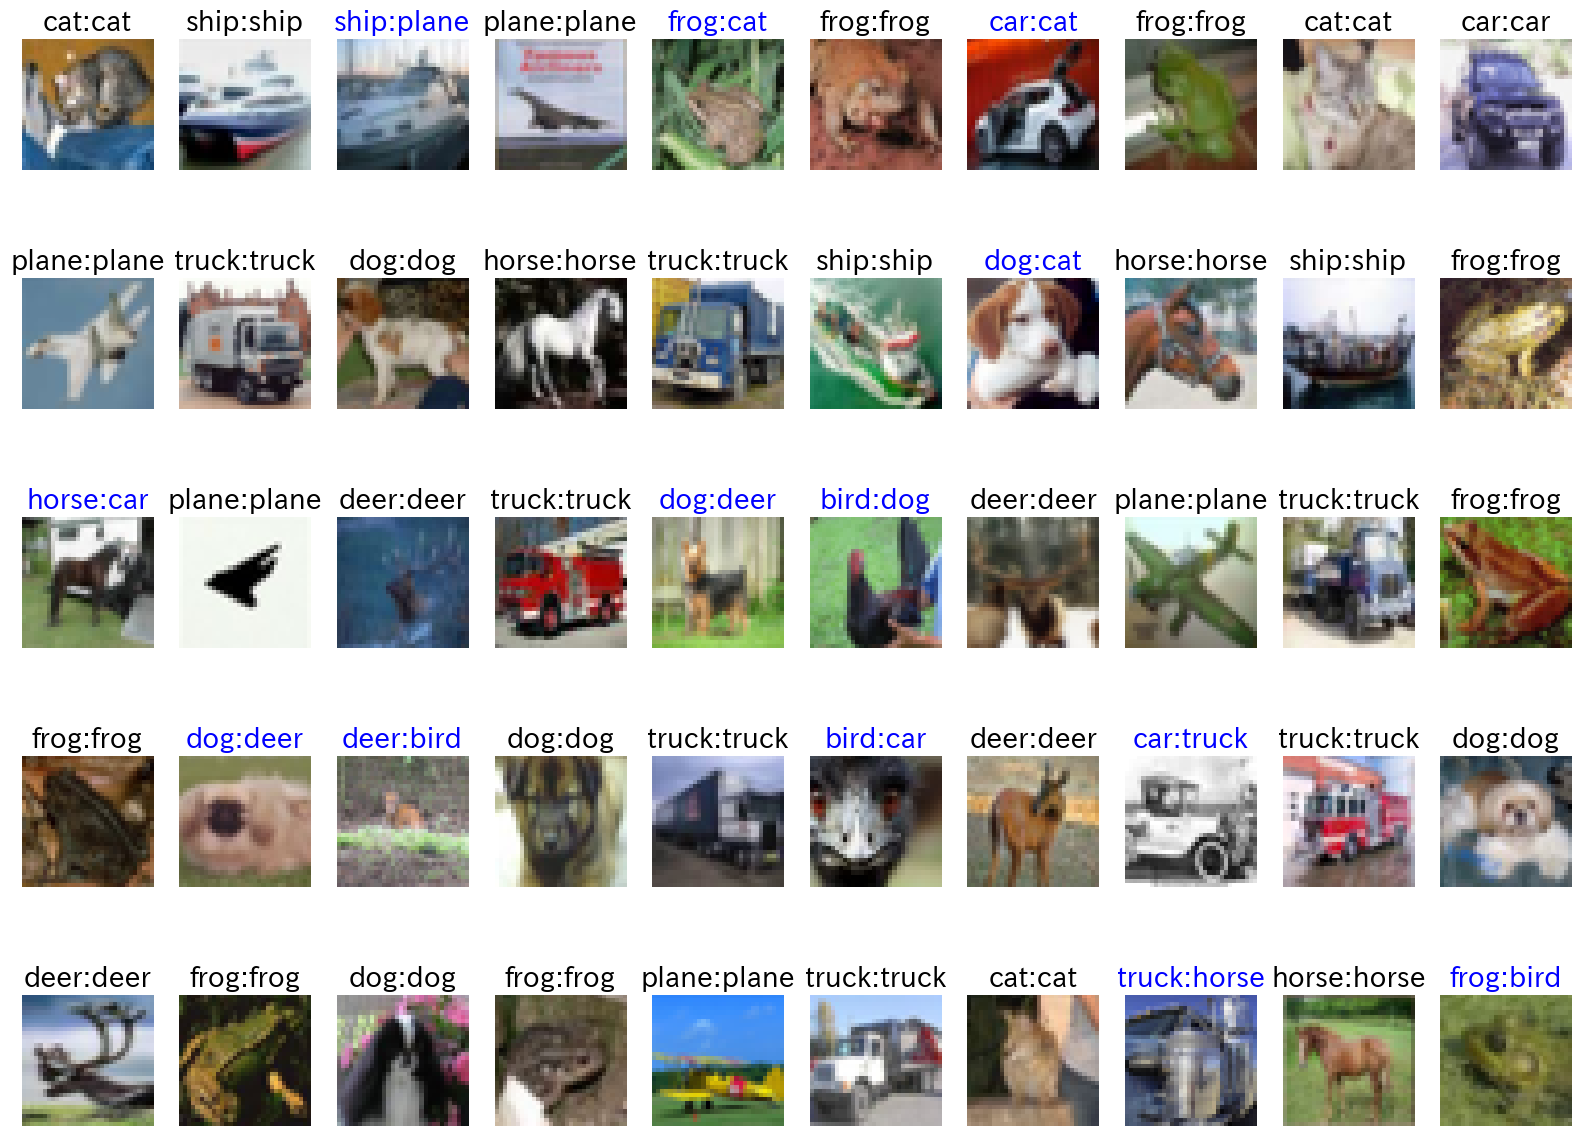

In [27]:
net = CNN(n_output, n_hidden).to(device)

criterion = nn.CrossEntropyLoss()

lr = 0.01

optimizer = torch.optim.SGD(net.parameters(), lr=lr)

print(net)
summary(net,(100,3,32,32),depth=1)

loss = eval_loss(test_loader2, device, net, criterion)

g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

torch_seed()

net = CNN(n_output, n_hidden).to(device)

criterion = nn.CrossEntropyLoss()

lr = 0.01

optimizer = optim.SGD(net.parameters(), lr=lr)

num_epochs = 50

history2 = np.zeros((0,5))
history2 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history2)
evaluate_history(history2)
show_images_labels(test_loader2, classes, net, device)
